## Problem definition and data description

### Problem Definition
Our company (Spotify) would like to dynamically target advertising to non-premium members based on their physical activity while using Spotify services. For example, while a listener is enjoying a podcast and folding their laundry, they would receive an ad for laundry detergent. 

In addition Spotify also wishes to cater to our premium members by enhancing music recommendation/auto-play options based on a members physical activity. For example, while a user is exercising play up-tempo music, and while a user is eating pasta play Italian classics.

### Data Description

Accelerometer and Gyroscope data was "collected from 51 subjects, each of whom were asked to perform 18 tasks for 3 minutes each. Each subject had a smartwatch placed on his/her dominant hand and a smartphone in their pocket... The sensor data that
was collected was from the accelerometer and gyrocope on both the smartphone and smartwatch, yielding four total sensors."

There are a total of 4 subdirectories, one for each device and sensor. 

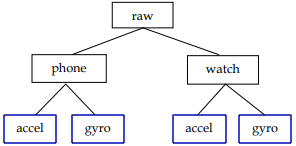


Each directory contains the sensor results for each subject's performance of the 18 activities. The results are stored in a text file with six attribute: Subject-id, Activity Code, Timestamp, x, y, z


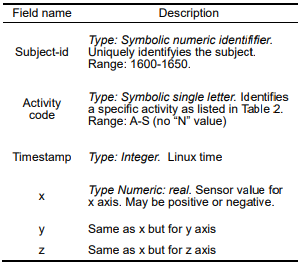





## Data preparation process

In [1]:
# %pip install plotly
# %pip install dash

In [2]:
seed=23

In [3]:
# libraries
import os
import pandas as pd
import numpy as np
#import plotly.express as px

import dask
import dask.dataframe as dd
from dask.distributed import Client
import joblib

# processing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# models
# will need to update these with the models we use
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

import ssl
# needed to request files when run from within docker container
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
# Start and connect to local client
client = Client()
client.connection_args

{'ssl_context': None, 'require_encryption': False, 'extra_conn_args': {}}

Get data from github and prep files for analysis

In [5]:
# key for understanding which activity is being measured in a record
activity_key_url = r"https://raw.githubusercontent.com/gojandrooo/DSE-230/main/data/activity_key.txt"

activity_key = pd.read_csv(activity_key_url, header=None)
activity_key = activity_key[0].str.replace(" ", "").str.split("=", expand=True)
activity_key.columns = ['activity', 'code']
activity_key

,activity,code
0,walking,A
1,jogging,B
2,stairs,C
3,sitting,D
4,standing,E
5,typing,F
6,teeth,G
7,soup,H
8,chips,I
9,pasta,J


In [6]:
# NOTE
# this still only grabs two spreadsheets, update for production

def collate_df(device, data_type):
    '''
    # returns a single dataframe from multiple spreadsheets hosted on github
    
    # device: ["phone", "watch"]
    
    # data_type: ["accel", "gyro"]
    '''
    
    base_url = r"https://raw.githubusercontent.com/gojandrooo/DSE-230/main/data"

    # TOGGLE FOR DEVICE
    device = device

    # TOGGLE FOR MEASUREMENT TYPE
    data_type = data_type
    
    # create list of all file names
    file_names = [f"/data_{user_id}_{data_type}_{device}.txt" for user_id in range(1600, 1651)]

    # create urls of all files
    loop_urls = [base_url + "/" + device + "/" + data_type + file_name for file_name in file_names]
    
    # merge data type in to one
    data_df = pd.concat([pd.read_csv(url, header=None) for url in loop_urls[:2]]) # for dev this is only the first two files
    data_df.columns = ['subject_id', 'code', 'timestamp', 'x', 'y', 'z']
    data_df['z'] = data_df['z'].str.replace(";", "").astype('float64')
    
    return data_df

In [7]:
collate_df?

In [8]:
phone_accel = collate_df("phone", "accel")
phone_accel

,subject_id,code,timestamp,x,y,z
0,1600,A,252207666810782,-0.364761,8.793503,1.055084
1,1600,A,252207717164786,-0.879730,9.768784,1.016998
2,1600,A,252207767518790,2.001495,11.109070,2.619156
3,1600,A,252207817872794,0.450623,12.651642,0.184555
4,1600,A,252207868226798,-2.164352,13.928436,-4.422485
...,...,...,...,...,...,...
81452,1601,S,258908699056416,2.015319,9.988011,0.746392
81453,1601,S,258908738947822,1.681927,10.074801,1.726219
81454,1601,S,258908778855321,1.148020,9.127296,1.492186
81455,1601,S,258908818435165,1.417966,9.126099,1.077989


In [9]:
"{:,.0f}".format(phone_accel.shape[0])

'145,768'

In [10]:
# watch_gyro = collate_df("watch", "gyro")
# watch_gyro

In [11]:
# # not rendering in docker image
# df = phone_accel
# fig = px.scatter_3d(df, x='x', y='y', z='z',
#               color='code')
# fig.show()

In [12]:
# # write out to excel (wireframe)
# file_name = 'file_name'
# writer = pd.ExcelWriter(f'{file_name}.xlsx', engine='xlsxwriter')
# df.to_excel(writer, sheet_name='sheet-name')
# writer.save()

In [13]:
# # output the to .tsv/csv (wireframe)
# file_name = 'file_name'
# df = df#.astype(str) #preserve dtype with str if not already
# # should output as .tsv to retain data structure
# df.to_csv(fr'{file_name}.tsv', sep='\t', index=False)

In [14]:
# # serialize file (wireframe)
# file_name = 'file_name'
# df = df
# df.to_pickle(f"./{file_name}.pkl")

In [15]:
# # read serialized file (wireframe)
# file_name = 'file_name'
# unpickled_df = pd.read_pickle(f"./{file_name}.pkl")

In [16]:
# # uncompress file and read in to dask (wireframe)
# file_name = 'file_name'
# unpickled_df = pd.read_pickle(f"./{file_name}.pkl")
# ddf = dd.from_pandas(unpickled_df, npartitions=8)

In [17]:
# write out file to csv
# needed so we can copy from local into hadoop
file_name = 'data_phone_accel'
df = phone_accel
# should output as .tsv to retain data structure
df.to_csv(fr'./prepped-data/{file_name}.csv')

In [18]:
# # read in file as a dask dataframe
# phone_accel = dd.read_csv(f"prepped-data/{file_name}.csv")

**<font color='red'>I don't think we actually need hadoop. saving in case we do and/or syntax for running other  bash commands</font>**

In [20]:
%%bash
dir

**create hadoop directory**

In [ ]:
%%bash
hadoop fs -mkdir /hdfs-data

**copy from local into hadoop**

In [ ]:
%%bash
hadoop fs -copyFromLocal prepped-data/data_phone_accel.csv /hdfs-data

**make sure file is in hadoop**

In [ ]:
%%bash
hadoop fs -ls /hdfs-data

- Use PySpark or Dask
- Include one classificationorregressionorclusteranalysis task
- Describe problem
    - To include:  Explain why problem is interesting, what real-life application is being addressed
- Describe analysis task
    - To include:  type of task (e.g., classification), how does task related to business problem
- Describe data
    - To include:  data quality issues, characteristics of the dataset (summary statistics,
correlation, outliers, etc.), plots
- Describe data preparation process
    - To include:  data cleaning steps, features used, train/validation/test datasets
- Describe analysis approaches
    - To include:  input, setup, and output of model(s)
- Describe challenges and solutions
    - To include:  challenges encountered, solutions to address challenges
- Describe analysis results and insights gained
    - To include:  discussion of results, insights gained from analysis
- Describe future work
    - To include:  lessons learned, next steps, what you would have done differently




Measures movement data over ten-second
intervals while subjects perform the various tasks.

## Analysis approaches

### Model Selection

<font color='red'>this section is wildly incomplete</font>
- To use the Dask backend to Joblib you have to create a Client, and wrap your scikit-learn code with joblib.parallel_backend('dask')

In [21]:
phone_accel.head()

,subject_id,code,timestamp,x,y,z
0,1600,A,252207666810782,-0.364761,8.793503,1.055084
1,1600,A,252207717164786,-0.879730,9.768784,1.016998
2,1600,A,252207767518790,2.001495,11.109070,2.619156
3,1600,A,252207817872794,0.450623,12.651642,0.184555
4,1600,A,252207868226798,-2.164352,13.928436,-4.422485


In [22]:
# split off labels
feat_cols = ['x', 'y', 'z']
label_col = ['code']

feature_df = phone_accel[feat_cols]
label_df = phone_accel[label_col]


X_train, x_test, y_train, y_test = train_test_split(feature_df, label_df, test_size=0.8, random_state=seed)

In [23]:
# scale data
# instatiate scaler
scaler = StandardScaler()
# fit the scaler
scalerModel = scaler.fit(X_train)
# scale the training data
X_train_scaled = scalerModel.transform(X_train)
# scale the test data
x_test_scaled = scalerModel.transform(x_test)

In [24]:
# set up grid search parameters
param_grid = {'max_depth'        : list(range(1, 10)),
              'min_samples_split': list(range(2, 10)),
              'criterion'        : ['gini','entropy']
             }

In [25]:
dt_model = DecisionTreeClassifier(random_state=seed)
dt_model_grid_dask = GridSearchCV(dt_model, param_grid, cv=10)
with joblib.parallel_backend("dask"):
    dt_model_grid_dask.fit(X_train_scaled, y_train)

In [26]:
print(dt_model_grid_dask.best_params_)

{'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 9}


In [27]:
print(dt_model_grid_dask.best_score_)

0.7840018634987189


## Analysis results

## Challenges & solutions

## Insights gained

## Future work

In [28]:
# always close client connection at end of workflow
client.shutdown()